# Customer Personality Analysis

## Table of contents
1. [Dataset](#introduction)
2. [Exploratory Data Analysis](#paragraph1)
3. [Refining the data](#paragraph2)
4. [Classification](#)
5. [Model Comparison](#)

## 1. Dataset

Attributes

People

 - ID: Customer's unique identifier
 - Year_Birth: Customer's birth year
 - Education: Customer's education level
 - Marital_Status: Customer's marital status
 - Income: Customer's yearly household income
 - Kidhome: Number of children in customer's household
 - Teenhome: Number of teenagers in customer's household
 - Dt_Customer: Date of customer's enrollment with the company
 - Recency: Number of days since customer's last purchase
 - Complain: 1 if the customer complained in the last 2 years, 0 otherwise


Products

 - MntWines: Amount spent on wine in last 2 years
 - MntFruits: Amount spent on fruits in last 2 years
 - MntMeatProducts: Amount spent on meat in last 2 years
 - MntFishProducts: Amount spent on fish in last 2 years
 - MntSweetProducts: Amount spent on sweets in last 2 years
 - MntGoldProds: Amount spent on gold in last 2 years


Promotion

 - NumDealsPurchases: Number of purchases made with a discount
 - AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
 - AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
 - AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
 - AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
 - AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
 - Response: 1 if customer accepted the offer in the last campaign, 0 otherwise


Place
 - NumWebPurchases: Number of purchases made through the company’s website
 - NumCatalogPurchases: Number of purchases made using a catalogue
 - NumStorePurchases: Number of purchases made directly in stores
 - NumWebVisitsMonth: Number of visits to company’s website in the last month


Target
Need to perform clustering to summarize customer segments.

Acknowledgement
The dataset for this project is provided by Dr. Omar Romero - Hernandez.

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from scipy import stats

In [55]:
df = pd.read_csv("data//marketing_campaign.csv",index_col=0,delimiter="\t")

In [56]:
#print(df.describe().T)
print(df)

       Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
ID                                                                         
5524         1957  Graduation         Single  58138.0        0         0   
2174         1954  Graduation         Single  46344.0        1         1   
4141         1965  Graduation       Together  71613.0        0         0   
6182         1984  Graduation       Together  26646.0        1         0   
5324         1981         PhD        Married  58293.0        1         0   
...           ...         ...            ...      ...      ...       ...   
10870        1967  Graduation        Married  61223.0        0         1   
4001         1946         PhD       Together  64014.0        2         1   
7270         1981  Graduation       Divorced  56981.0        0         0   
8235         1956      Master       Together  69245.0        0         1   
9405         1954         PhD        Married  52869.0        1         1   

      Dt_Cu

In [57]:
quantitative = [c for c in df.columns if df.dtypes[c] != 'object']
qualitative = [c for c in df.columns if df.dtypes[c] == 'object']


In [58]:
missing_values = pd.isnull(df).sum().sort_values(ascending=True)
print(missing_values[missing_values>0])

Income    24
dtype: int64


In [59]:
print(df.columns)

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


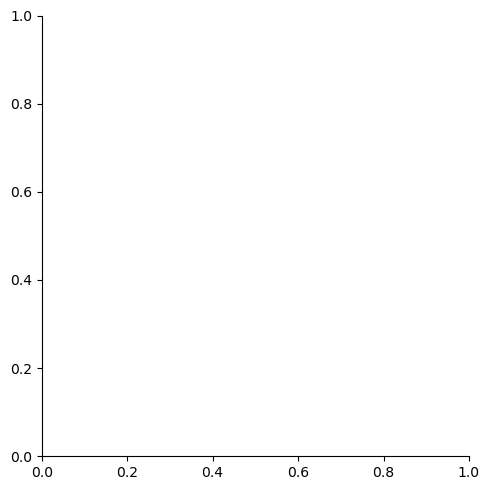

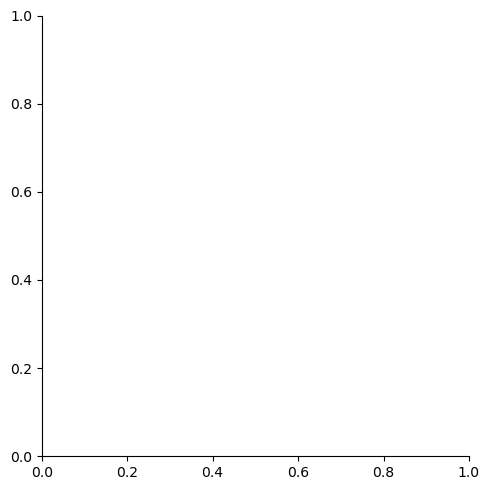

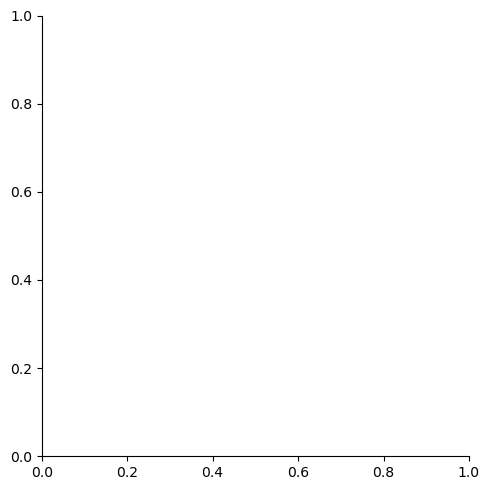

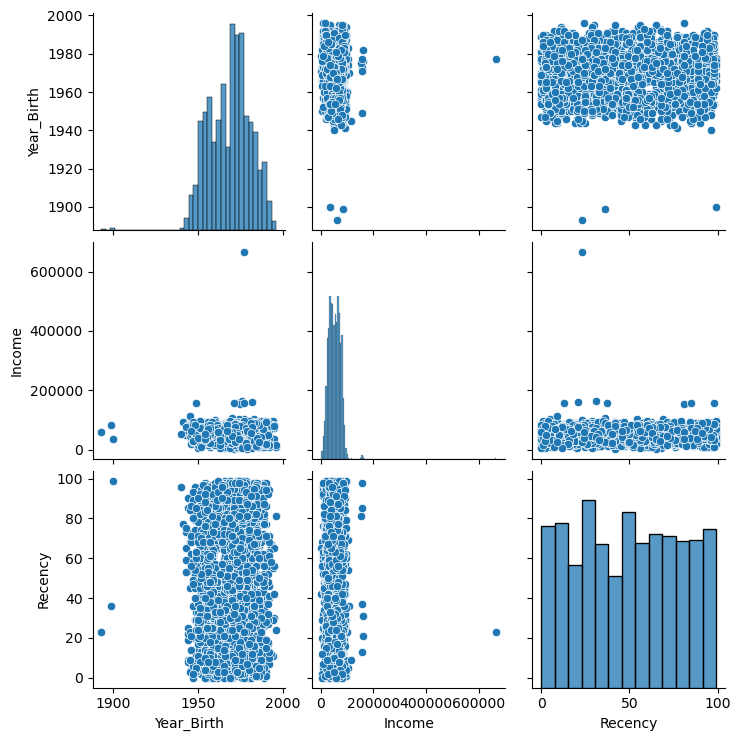

In [60]:

vars_corr = ["Year_Birth","Income","Recency"]

sns.pairplot(df[vars_corr])
plt.show()

In [61]:
print(quantitative)
print(qualitative)

['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']
['Education', 'Marital_Status', 'Dt_Customer']


## Refining data

Remove Nan Values

In [65]:
eda_df = df.copy()
print(df[(np.abs(stats.zscore(df["Income"])) < 2)])
#eda_df[c] = df[(np.abs(stats.zscore(df[c])) < 2)]
#print(eda_df)


       Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
ID                                                                         
5524         1957  Graduation         Single  58138.0        0         0   
2174         1954  Graduation         Single  46344.0        1         1   
4141         1965  Graduation       Together  71613.0        0         0   
6182         1984  Graduation       Together  26646.0        1         0   
5324         1981         PhD        Married  58293.0        1         0   
...           ...         ...            ...      ...      ...       ...   
10870        1967  Graduation        Married  61223.0        0         1   
4001         1946         PhD       Together  64014.0        2         1   
7270         1981  Graduation       Divorced  56981.0        0         0   
8235         1956      Master       Together  69245.0        0         1   
9405         1954         PhD        Married  52869.0        1         1   

      Dt_Cu

In [63]:
# print(df[df[["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5"]].sum(axis=1)> 1])
# print(df[["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5"]].sum(axis=1))
sns.displot(eda_df["Income"])
print(eda_df)
print(eda_df["Income"])

Empty DataFrame
Columns: [Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response]
Index: []

[0 rows x 28 columns]
Series([], Name: Income, dtype: float64)
